<a href="https://colab.research.google.com/github/Dheeraj1508/EmergencyVehicleClassification/blob/main/traffic_sign_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
import shutil
import pandas as pd
import numpy as np
import torch
import torchvision
import os

In [7]:
os.makedirs('/root/.kaggle')

In [10]:
!mv /content/kaggle.json ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d ahemateja19bec1025/traffic-sign-dataset-classification

100% 190M/190M [00:09<00:00, 22.0MB/s]
100% 190M/190M [00:09<00:00, 20.5MB/s]


In [ ]:
!unzip traffic-sign-dataset-classification

In [44]:

df = pd.read_csv("labels.csv")

In [18]:
df[df.Name.apply(lambda x : x in ['Speed limit (50km/h)','Speed limit (40km/h)','Bicycles crossing'])]

,ClassId,Name
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)
18,18,Speed limit (40km/h)
19,19,Speed limit (50km/h)
30,30,Bicycles crossing
36,36,Bicycles crossing


In [22]:
# Define source and destination folders
source_folder = 'traffic_Data/DATA/4'
destination_folder = 'traffic_Data/DATA/3'

# # List the files in the source folder
files_to_move = os.listdir(source_folder)

# Loop through the files and move them to the destination folder
for file_name in files_to_move:
    source_file = os.path.join(source_folder, file_name)
    destination_file = os.path.join(destination_folder, file_name)

    # Use shutil.move to move the file
    shutil.move(source_file, destination_file)

print("Images moved successfully.")

Images moved successfully.


In [23]:
shutil.rmtree('traffic_Data/DATA/4')
shutil.rmtree('traffic_Data/DATA/36')
shutil.rmtree('traffic_Data/DATA/19')


In [34]:
unknown_list =df[df.Name.apply(lambda x : 'unknown' in x.lower())]['ClassId'].values
unknown_list

array([40, 41, 42, 45, 49, 52, 56, 57])

In [33]:
for i in unknown_list:
  shutil.rmtree('traffic_Data/DATA/'+str(i))

In [37]:
len(os.listdir('traffic_Data/DATA'))

47

In [16]:
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import  random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet statistics
])

dataset = torchvision.datasets.ImageFolder(root='traffic_Data/DATA/', transform=transform)
# testset = torchvision.datasets.ImageFolder(root='traffic-sign-dataset-classification/traffic_Data/', transform=transform)
train_size = int(0.9 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

# Use random_split to split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [38]:
batch_size=4
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)
dataloaders={'train':trainloader,'val':testloader}

In [51]:
df[df.index==0]['Name'].values[0]

'Speed limit (5km/h)'

In [39]:


dataset_sizes = {'train': len(train_dataset),'val':len(test_dataset)}
class_names = dataset.classes

In [56]:
df.head()

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)


In [70]:
class_names=[]
for i in dataset.classes:
  class_names.append(df[df.ClassId==int(i)]['Name'].values[0])

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print(device)
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU")

GPU is available
cuda


In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
import torch.optim as optim
from torchvision import models
# dir(models)


In [18]:
net = models.convnext_small(weights=models.ConvNeXt_Small_Weights.IMAGENET1K_V1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD( net.parameters(), lr=0.001, momentum=0.9)


In [10]:
net.classifier[-1] = nn.Linear(in_features=768,out_features=47,bias=True)

In [11]:
net.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=47, bias=True)
)

In [12]:
torch.cuda.is_available()

True

In [19]:
from tqdm import tqdm
import torch

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Move your network and criterion to the selected device
net =net.to(device)
criterion=criterion.to(device)
print(optimizer)


cuda
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
cudnn.benchmark = True
plt.ion()   # interactive mode

In [22]:
# for epoch in range(25):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in tqdm(enumerate(trainloader, 0)):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0
#     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')

# print('Finished Training')


In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [67]:

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [28]:
# model_ft = models.convnext_small(weights='IMAGENET1K_V1')
# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
# model_ft.fc = nn.Linear(num_ftrs, 47)
# net=net

# criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [41]:
model_ft = train_model(net, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

Epoch 0/3
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.0003 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.0003 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.0003 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.0003 Acc: 1.0000

Training complete in 8m 31s
Best val Acc: 1.000000


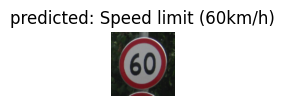

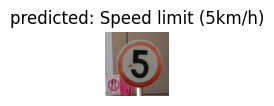

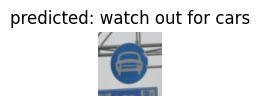

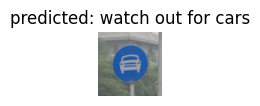

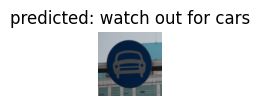

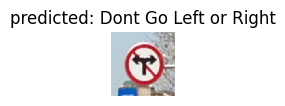

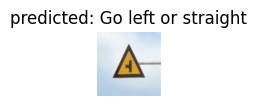

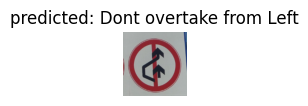

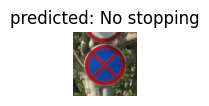

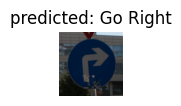

In [75]:
visualize_model(net,num_images=10)

In [77]:
torch.save(net.state_dict(),'best_model.pth')